In [1]:
!pip list



Package                      Version
---------------------------- ------------
absl-py                      2.0.0
altair                       5.1.2
asttokens                    2.4.0
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
blinker                      1.6.3
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.2.0
click                        8.1.7
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.11.0
debugpy                      1.8.0
decorator                    5.1.1
executing                    1.2.0
filelock                     3.12.4
flatbuffers                  23.5.26
fonttools                    4.42.1
gast                         0.4.0
gdown                        4.7.1
gitdb                        4.0.11
GitPython                    3.1.4


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install matplotlib imageio gdown tensorflow


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
!pip list


Package                      Version
---------------------------- ------------
absl-py                      2.0.0
altair                       5.1.2
asttokens                    2.4.0
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
blinker                      1.6.3
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.2.0
click                        8.1.7
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.11.0
debugpy                      1.8.0
decorator                    5.1.1
executing                    1.2.0
filelock                     3.12.4
flatbuffers                  23.5.26
fonttools                    4.42.1
gast                         0.4.0
gdown                        4.7.1
gitdb                        4.0.11
GitPython                    3.1.4


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!nvidia-smi

In [ ]:
tf.__version__

In [ ]:
tf.config.list_physical_devices('GPU')


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass


# DATA LOADING

In [2]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = [] ### LOOPING THROUGH EACH FRAME AND STORING IT IN FRAMES ARRAY
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)  # MAKING IT ESIER TO PREPROCESS
        frames.append(frame[190:236,80:220,:]) # ISOLATING MOUTH REGION
    cap.release()
    
    mean = tf.math.reduce_mean(frames) #CALCULATING MEAN
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) #CALCULATING STD
    return tf.cast((frames - mean), tf.float32) / std #SCALING THE DATA WITH MEAN AND STD 

#### RETURNS FLOATS WHICH REPRESENTS OUR VIDEO

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [4]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") # IF CHAR NOT SEEN B4 WE WILL GIVE IT ""
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
) # WE WANT TO CONVERT NUMS TO CHAR NOT THE OTHERE WAY ROUND SO INVERT=TRUE

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [5]:
char_to_num.get_vocabulary()


['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [6]:
char_to_num(['a','r','y','a','m','a','n'])


<tf.Tensor: shape=(7,), dtype=int64, numpy=array([ 1, 18, 25,  1, 13,  1, 14], dtype=int64)>

In [7]:
num_to_char( [1, 18, 25,  1, 13,  1, 14])

<tf.Tensor: shape=(7,), dtype=string, numpy=array([b'a', b'r', b'y', b'a', b'm', b'a', b'n'], dtype=object)>

In [8]:
def load_alignments(path:str) -> List[str]:
    #OPENING PATHS AND SPLITTING LINES
    with open(path, 'r') as f:   
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [9]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    # TAKING PATH TO VIDEO THEN WE WILL SPLIT IT TO VIDEO AND ALIGNENT PATH SO THT WE CAN SEND INPUT SIMULTANEOUSLY
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [10]:
test_path = '.\\data\\s1\\bbal6n.mpg'


In [11]:
# CONVERTING TO TensorFlow tensor()

tf.convert_to_tensor(test_path).numpy().decode('utf-8')


'.\\data\\s1\\bbal6n.mpg'

In [12]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')

['.', 'data', 's1', 'bbal6n.mpg']

In [13]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1]                 # -1 GRABBING LAAST ELEMENT

'bbal6n.mpg'

In [14]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')                 # -1 GRABBING LAAST ELEMENT

['bbal6n', 'mpg']

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]     

'bbal6n'

In [16]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


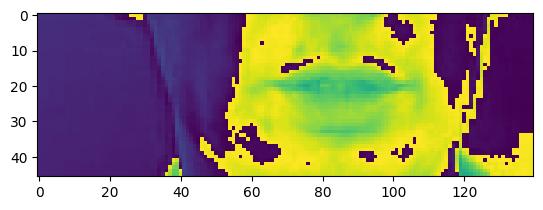

In [17]:
plt.imshow(frames[30])


In [18]:
alignments


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [19]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [20]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Create Data Pipeline

In [21]:
from matplotlib import pyplot as plt


In [22]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# EACH ALIGNMENT WILL HAVE VARIABLEL LENGTH SOO W USE PADDING TO MAKE IT SAME LENGTH. EW IWLL HAVE 2 SETS OF VIDEOS IN EACH DATA . 40 SETS OF TOKENS. IF <40 WE WILL PADD ZRO
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [23]:
len(test)


50

In [24]:
frames, alignments = data.as_numpy_iterator().next()


In [25]:
frames

array([[[[[ 1.4450927 ],
          [ 1.4450927 ],
          [ 1.4450927 ],
          ...,
          [ 0.28901854],
          [ 0.32514584],
          [ 0.32514584]],

         [[ 1.4450927 ],
          [ 1.4450927 ],
          [ 1.4450927 ],
          ...,
          [ 0.28901854],
          [ 0.32514584],
          [ 0.32514584]],

         [[ 1.5173473 ],
          [ 1.5173473 ],
          [ 1.48122   ],
          ...,
          [ 0.32514584],
          [ 0.36127317],
          [ 0.36127317]],

         ...,

         [[ 1.0476922 ],
          [ 1.0115649 ],
          [ 1.0115649 ],
          ...,
          [ 0.07225464],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.0115649 ],
          [ 1.0115649 ],
          [ 1.0115649 ],
          ...,
          [ 0.07225464],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.0115649 ],
          [ 1.0115649 ],
          [ 1.0115649 ],
          ...,
          [ 0.07225464],
          [ 0.        ],
          

In [26]:
alignments  # 2 SETS OF ALIGNMENTS

array([[12,  1, 25, 39, 18,  5,  4, 39,  1, 20, 39, 11, 39, 14,  9, 14,
         5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  2, 25, 39,  8, 39, 26,
         5, 18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [27]:
len(frames)


2

In [28]:
sample = data.as_numpy_iterator()


In [29]:
val = sample.next(); val[0]


array([[[[[1.4761443 ],
          [1.4761443 ],
          [1.5139941 ],
          ...,
          [0.15139942],
          [0.34064868],
          [0.30279884]],

         [[1.4761443 ],
          [1.4761443 ],
          [1.5139941 ],
          ...,
          [0.11354956],
          [0.30279884],
          [0.22709912]],

         [[1.3625947 ],
          [1.3625947 ],
          [1.3625947 ],
          ...,
          [0.30279884],
          [0.34064868],
          [0.34064868]],

         ...,

         [[1.0597959 ],
          [1.0597959 ],
          [1.0219461 ],
          ...,
          [0.        ],
          [9.651712  ],
          [9.651712  ]],

         [[1.0597959 ],
          [1.0597959 ],
          [1.0219461 ],
          ...,
          [0.03784985],
          [0.        ],
          [0.        ]],

         [[1.0597959 ],
          [1.0597959 ],
          [1.0219461 ],
          ...,
          [0.03784985],
          [0.        ],
          [0.        ]]],


        [[[1.4382

In [30]:
val[0][0]

array([[[[1.4761443 ],
         [1.4761443 ],
         [1.5139941 ],
         ...,
         [0.15139942],
         [0.34064868],
         [0.30279884]],

        [[1.4761443 ],
         [1.4761443 ],
         [1.5139941 ],
         ...,
         [0.11354956],
         [0.30279884],
         [0.22709912]],

        [[1.3625947 ],
         [1.3625947 ],
         [1.3625947 ],
         ...,
         [0.30279884],
         [0.34064868],
         [0.34064868]],

        ...,

        [[1.0597959 ],
         [1.0597959 ],
         [1.0219461 ],
         ...,
         [0.        ],
         [9.651712  ],
         [9.651712  ]],

        [[1.0597959 ],
         [1.0597959 ],
         [1.0219461 ],
         ...,
         [0.03784985],
         [0.        ],
         [0.        ]],

        [[1.0597959 ],
         [1.0597959 ],
         [1.0219461 ],
         ...,
         [0.03784985],
         [0.        ],
         [0.        ]]],


       [[[1.4382944 ],
         [1.4382944 ],
         [1.51

In [31]:
val[0][1]


array([[[[1.3302966 ],
         [1.3302966 ],
         [1.3302966 ],
         ...,
         [9.274068  ],
         [9.350085  ],
         [9.198051  ]],

        [[1.3302966 ],
         [1.3302966 ],
         [1.3302966 ],
         ...,
         [8.47589   ],
         [9.274068  ],
         [9.46411   ]],

        [[1.2922882 ],
         [1.2922882 ],
         [1.2922882 ],
         ...,
         [9.426102  ],
         [9.616144  ],
         [9.616144  ]],

        ...,

        [[0.91220343],
         [0.91220343],
         [0.8741949 ],
         ...,
         [9.616144  ],
         [9.616144  ],
         [9.616144  ]],

        [[0.91220343],
         [0.91220343],
         [0.8741949 ],
         ...,
         [9.540128  ],
         [9.5781355 ],
         [9.5781355 ]],

        [[0.91220343],
         [0.91220343],
         [0.8741949 ],
         ...,
         [9.540128  ],
         [9.5781355 ],
         [9.5781355 ]]],


       [[[1.3302966 ],
         [1.3302966 ],
         [1.33

In [32]:
val_pixels = (val[0][1].astype(np.uint8)*255).squeeze()

In [33]:
imageio.mimsave('./animation.gif', val_pixels, duration=50)

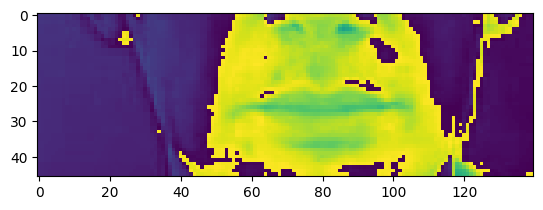

In [34]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][74])

In [35]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'lay white by z seven again'>

# DEEP NEURAL N/W

In [36]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [37]:
data.as_numpy_iterator().next()[0][0].shape
# 75 FRAMES IN LENGTH,HEIGHT,WIDTH,

(75, 46, 140, 1)

In [38]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [39]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [40]:
yhat = model.predict(val[0])


1/1 [==============================] - 5s 5s/step


In [41]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b'ncccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc'>

In [42]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'ncccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc'>

In [43]:
model.input_shape


(None, 75, 46, 140, 1)

In [44]:
model.output_shape


(None, 75, 41)

# Setup Training Options and Training

In [45]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [46]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [47]:
class PE(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 


In [ ]:
schedule_callback = LearningRateScheduler(scheduler)


In [ ]:
example_callback = PE(test)


In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


# PREDICTIONS

In [48]:
model.load_weights('models/checkpoint')


In [49]:
test_data = test.as_numpy_iterator()


In [ ]:
sample = test_data.next()


In [ ]:
yhat = model.predict(sample[0])


In [ ]:
print('~'*50, 'REAL TEXT','~'*50)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()


In [ ]:
print('~'*50, 'PREDICTIONS','~'*50)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


# VIDEO TEST

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bbaf4p.mpg'))


In [ ]:
print('~'*50, 'REAL TEXT','~'*50)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]


In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()


In [ ]:
print('~'*50, 'PREDICTIONS','~'*50)

[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


# MODEL ACCURACY

In [ ]:
pip install jiwer

In [ ]:
import jiwer



In [ ]:
original_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in [sample[1]]]

print('~' * 100, 'ORG TEXT')
print(original_text)

In [ ]:
decoded_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in decoded]

print('~' * 100, 'PREDICTIONS')
print(decoded_text)

In [ ]:
error = jiwer.wer(original_text, decoded_text)
print(f"Word Error Rate: {error}")

In [ ]:
original_texts = []
decoded_texts = []

In [ ]:
test_data = test.as_numpy_iterator()


In [ ]:
for sample in test_data:
    yhat = model.predict(sample[0])
    original_texts.extend([tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in sample[1]])
    decoded_texts.extend([tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()])



In [ ]:
# Calculate the Word Error Rate (WER) for the entire model
error = jiwer.wer(original_texts, decoded_texts)
print(f"Word Error Rate for the entire model: {error}")